In [1]:
# import all the necessary libraries for time-seires analysis and network analysis
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import os
import sys
import math
import random
import itertools
import operator
import collections
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
import osmnx as ox
import time
import geopandas as gpd
from shapely.wkt import loads as load_wkt
from shapely.geometry import LineString, MultiLineString
from shapely.geometry import Point
import random
import matplotlib.patheffects as PathEffects

c:\Users\SBH\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
"""
# import the city boundary shp file
city_boundary = gpd.read_file('Data/python/Area_boundary.shp')
city_boundary[city_boundary['display_na'] == 'Nanjing City, Jiangsu, China']
# change the name from 'Nanjing City' to 'Nanjing', display_na from 'Nanjing City, Jiangsu, China' to 'Nanjing, Jiangsu, China'
city_boundary.loc[city_boundary['display_na'] == 'Nanjing City, Jiangsu, China', 'display_na'] = 'Nanjing, Jiangsu, China'
city_boundary.loc[city_boundary['name'] == 'Nanjing City', 'name'] = 'Nanjing'
city_boundary[city_boundary['display_na'] == 'Nanjing, Jiangsu, China']
# save the city boundary as a shapefile
city_boundary.to_file('Data/python/Area_boundary.shp')
"""

"\n# import the city boundary shp file\ncity_boundary = gpd.read_file('Data/python/Area_boundary.shp')\ncity_boundary[city_boundary['display_na'] == 'Nanjing City, Jiangsu, China']\n# change the name from 'Nanjing City' to 'Nanjing', display_na from 'Nanjing City, Jiangsu, China' to 'Nanjing, Jiangsu, China'\ncity_boundary.loc[city_boundary['display_na'] == 'Nanjing City, Jiangsu, China', 'display_na'] = 'Nanjing, Jiangsu, China'\ncity_boundary.loc[city_boundary['name'] == 'Nanjing City', 'name'] = 'Nanjing'\ncity_boundary[city_boundary['display_na'] == 'Nanjing, Jiangsu, China']\n# save the city boundary as a shapefile\ncity_boundary.to_file('Data/python/Area_boundary.shp')\n"

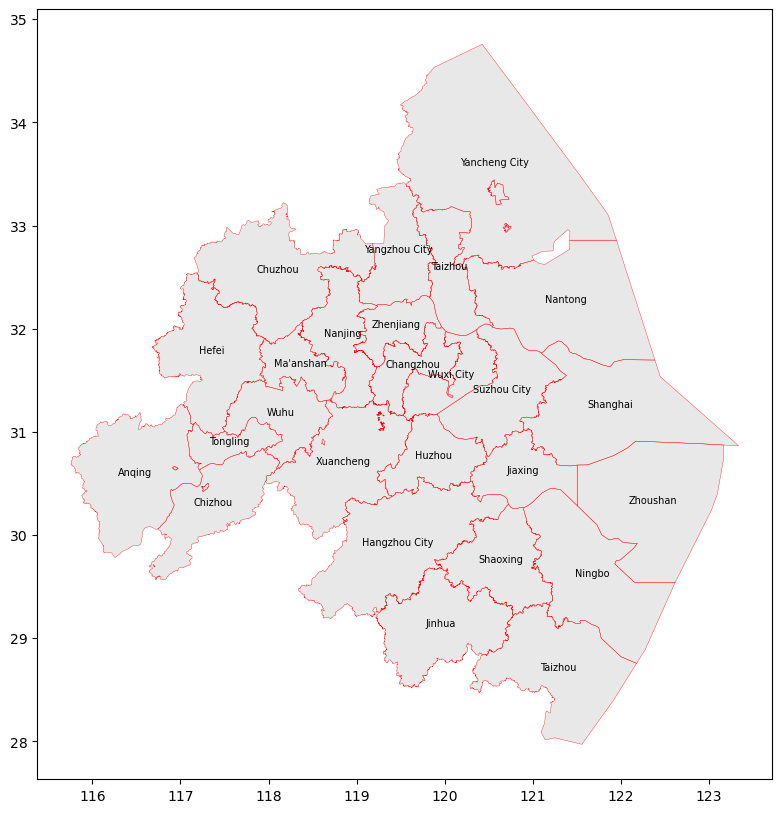

In [3]:
# import the city boundary shp file
city_boundary = gpd.read_file('Data/python/Area_boundary.shp')
# plot the city boundary
# plot the gdf data, and add the basemap
fig, ax = plt.subplots(figsize=(10,10))
city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)
# fill the boundary with a color
city_boundary.plot(ax=ax, facecolor='lightgray', alpha=0.5)
# label the city name, set the font size to 5
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7), axis=1)

# add the basemap
#ctx.add_basemap(ax, crs=city_boundary.crs, source=ctx.providers.OpenStreetMap.DE)
plt.show()

### Read the road network graphml

In [4]:
# load the road network data
G = nx.read_graphml('Data/python/combined_road_network.graphml')

In [5]:
#check how many nodes with each unique city_name attribute
city_names = [data['city_name'] for node, data in G.nodes(data=True)]
city_name_counts = Counter(city_names)
# save the city_name_counts to a pandas dataframe
city_name_counts_df = pd.DataFrame.from_dict(city_name_counts, orient='index').reset_index()
city_name_counts_df.columns = ['city_name', 'count']
city_name_counts_df = city_name_counts_df.sort_values(by='count', ascending=False)

In [6]:
# Convert geometry strings back to shapely objects if necessary
for u, v, data in G.edges(data=True):
    if 'geometry' in data:
        if isinstance(data['geometry'], str):
            data['geometry'] = load_wkt(data['geometry'])
# convert all 'length' attributes to float type
for u, v, data in G.edges(data=True):
    data['length'] = float(data['length'])


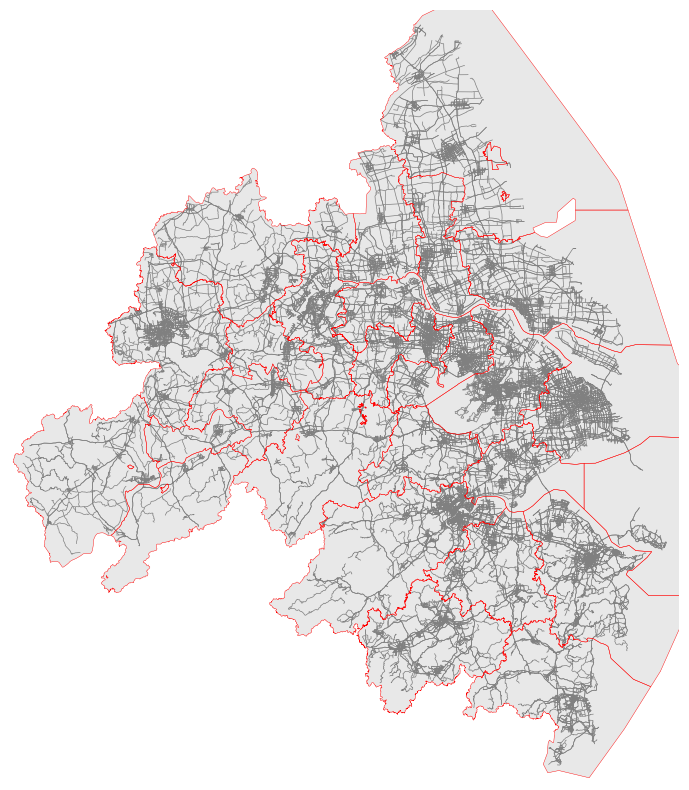

In [10]:

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the city boundary fill color first
city_boundary.plot(ax=ax, facecolor='lightgray', alpha=0.5)

# Plot the city boundary outline on top of the fill color
city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.3, alpha=1)

# Label the city name, set the font size to 7, font weight to bold, and add white outline
def annotate_city(row, ax):
    text = ax.annotate(
        text=row['name'], 
        xy=row.geometry.centroid.coords[0], 
        ha='center', 
        fontsize=7, 
        fontweight='bold',
        color='black'
    )
    text.set_path_effects([
        PathEffects.Stroke(linewidth=3, foreground='white'),
        PathEffects.Normal()
    ])

city_boundary.apply(lambda x: annotate_city(x, ax), axis=1)

# Set the x and y limits based on the city boundary
xmin, ymin, xmax, ymax = city_boundary.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Now plot the graph on top of the city boundary
ox.plot_graph(G, ax=ax, node_size=0.1, edge_linewidth=0.5, bgcolor='white', show=False, close=False, edge_color='gray')

plt.show()

In [68]:
node_list = list(G.nodes(data=True))
edge_list = list(G.edges(data=True))
# select 4 random nodes from the list
random_selection = random.sample(edge_list, 2)
random_selection

[('2029959269',
  '2029959276',
  {'osmid': '192439932',
   'oneway': 'True',
   'ref': 'Chengbei road',
   'name': '城北路',
   'highway': 'primary',
   'reversed': 'False',
   'length': 29.722}),
 ('6992914166',
  '11043476307',
  {'osmid': '747346783',
   'oneway': 'True',
   'lanes': '1',
   'highway': 'primary',
   'reversed': 'False',
   'length': 839.6030000000001,
   'geometry': <LINESTRING (119.933 32.393, 119.933 32.392, 119.933 32.39, 119.933 32.388, ...>})]

In [69]:
# generate a list of city pairs, if any two cities in city_boundary have shared boundaries (i.e., are adjacent), then add the city pair to this list of lists
city_pairs = []
for idx1, row1 in city_boundary.iterrows():
    for idx2, row2 in city_boundary.iterrows():
        if row1['geometry'].intersects(row2['geometry']) and row1['display_na'] != row2['display_na']:
            city_pairs.append([row1['display_na'], row2['display_na']])
len(city_pairs)

126

In [70]:
# remove all the duplicates in the city_pairs list, including the reversed pairs
city_pairs = list(set([tuple(sorted(pair)) for pair in city_pairs]))
city_pairs = [list(pair) for pair in city_pairs]  # convert the list of tuples back to a list of lists
len(city_pairs)

63

In [71]:
# convert this list to a pandas dataframe, where each row is a city pair, columns are 'city1' and 'city2'
city_pairs_df = pd.DataFrame(city_pairs, columns=['city1', 'city2'])
# create a new column 'city_distance' filled with 0
city_pairs_df['city_distance'] = 0.000
city_pairs_df.sample(5)

,city1,city2,city_distance
45,"Huzhou, Zhejiang, China","Jiaxing, Zhejiang, China",0.0
8,"Hefei, Anhui, China","Ma'anshan, Anhui, China",0.0
34,"Chizhou, Anhui, China","Xuancheng, Anhui, China",0.0
26,"Chuzhou, Anhui, China","Yangzhou City, Jiangsu, China",0.0
17,"Nanjing, Jiangsu, China","Xuancheng, Anhui, China",0.0


In [72]:
# read the city_pairs_df dataframe from the csv file, get the edge weight matrix
city_pairs_df = pd.read_csv('Data/python/city_distance_network.csv')
city_pairs_df.sample(5)

,city1,city2,city_distance,num_nodepair,city1_num_nodes,city2_num_nodes,city_distance_index
14,"Hefei, Anhui, China","Tongling, Anhui, China",1.714291e+09,10085.6800,6424,628,169972.744677
13,"Huzhou, Zhejiang, China","Xuancheng, Anhui, China",1.144096e+09,6723.3050,2131,1262,170168.682684
58,"Ma'anshan, Anhui, China","Wuhu, Anhui, China",3.065116e+08,3883.1100,902,1722,78934.564974
21,"Jiaxing, Zhejiang, China","Ningbo, Zhejiang, China",1.014248e+10,65501.2125,3543,7395,154844.170297
24,"Hangzhou City, Zhejiang, China","Jinhua, Zhejiang, China",1.328020e+10,87905.8000,8293,4240,151073.044167


### Create a undirected graph for city's spatial accessbility network

In [73]:
#download the city's coordinates from the OpenStreetMap
# construct the city'list for its specific name in OSM
city_namelist_OSM = ['Suzhou City, Jiangsu, China','Yangzhou City, Jiangsu, China','Anqing, Anhui, China','Changzhou, Jiangsu, China', 'Chizhou, Anhui, China',
                 '滁州市','Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China','Huzhou, Zhejiang, China','Jiaxing, Zhejiang, China',
                 'Jinhua, Zhejiang, China',"Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China','Nantong, Jiangsu, China','Ningbo, Zhejiang, China',
                 'Shaoxing, Zhejiang, China','Taizhou, Zhejiang, China','Taizhou, Jiangsu, China','Tongling, Anhui, China','Wuxi City, Jiangsu, China',
                 'Wuhu, Anhui, China','Xuancheng, Anhui, China','Yancheng City, Jiangsu, China','Zhenjiang, Jiangsu, China','Zhoushan, Zhejiang, China','Shanghai, China']
city_namelist_OSM_en = ['Suzhou City, Jiangsu, China','Yangzhou City, Jiangsu, China','Anqing, Anhui, China','Changzhou, Jiangsu, China', 'Chizhou, Anhui, China',
                 'Chuzhou, Anhui, China','Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China','Huzhou, Zhejiang, China','Jiaxing, Zhejiang, China',
                 'Jinhua, Zhejiang, China',"Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China','Nantong, Jiangsu, China','Ningbo, Zhejiang, China',
                 'Shaoxing, Zhejiang, China','Taizhou, Zhejiang, China','Taizhou, Jiangsu, China','Tongling, Anhui, China','Wuxi City, Jiangsu, China',
                 'Wuhu, Anhui, China','Xuancheng, Anhui, China','Yancheng City, Jiangsu, China','Zhenjiang, Jiangsu, China','Zhoushan, Zhejiang, China','Shanghai, China']

# download each city's osmid and save it into a list
city_osmid = []

for city_name in city_namelist_OSM:
    try:
        # get the city's geographic data
        gdf = ox.geocode_to_gdf(city_name)
        city_osmid.append(gdf.osm_id.iloc[0])
    except Exception as e:
        print(f"Error retrieving data for {city_name}: {e}")


In [74]:
# download each city's center's coordinates data
city_centers = {}

# Iterate over the list of cities to get the boundary and center coordinates of each city
for i in range(len(city_osmid)):
    try:
        # get the city's geographic data
        gdf = ox.geocode_to_gdf(f"R{city_osmid[i]}", by_osmid=True)
        
        # convert the geographic data to the Web Mercator projection
        gdf_projected = gdf.to_crs(epsg=4326)
        
        # get the center of the city coordinates
        center = gdf_projected.geometry.centroid.iloc[0]
        
        # save the city's center coordinates to a dict
        city_centers[city_namelist_OSM_en[i]] = (center.x, center.y)
        
    except Exception as e:
        print(f"Error retrieving data for {city_namelist_OSM_en[i]}: {e}")

C:\Users\SBH\AppData\Local\Temp\ipykernel_26760\3815955199.py:14: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\SBH\AppData\Local\Temp\ipykernel_26760\3815955199.py:14: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\SBH\AppData\Local\Temp\ipykernel_26760\3815955199.py:14: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\SBH\AppData\Local\Temp\ipykernel_26760\3815955199.py:14: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this o

In [75]:
# create an undirected graph
G_accessbility = nx.Graph()


# add the nodes to the network
for city_name, coords in city_centers.items():
    G_accessbility.add_node(city_name, pos=coords)

# check and print the number of nodes in the network
print(G_accessbility.number_of_nodes())

26


In [76]:
# import the city distance network data
city_pairs_all_df = pd.read_csv('Data/python/city_distance_all_network.csv')


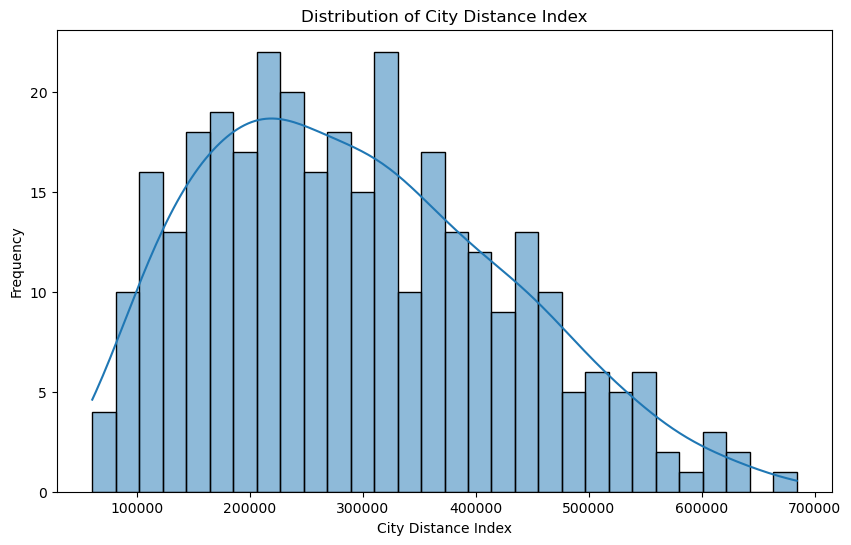

In [77]:
# plot the histogram of 'city_distance_index' column
plt.figure(figsize=(10, 6))
sns.histplot(city_pairs_all_df['city_distance_index'], bins=30, kde=True)
plt.title('Distribution of City Distance Index')
plt.xlabel('City Distance Index')
plt.ylabel('Frequency')
plt.show()

In [78]:
# doing some transformation to the city_distance_index value in the city_pairs_all_df dataframe
# take the z-score normalization to the city_distance_index value
city_pairs_all_df['city_distance_index_norm'] = (city_pairs_all_df['city_distance_index'] - city_pairs_all_df['city_distance_index'].mean()) / city_pairs_all_df['city_distance_index'].std()
city_pairs_all_df['city_distance_index_norm'] = city_pairs_all_df['city_distance_index_norm'].apply(lambda x: round(x, 5))
# reverse the value of the city_distance_index_norm
city_pairs_all_df['city_distance_index_norm'] = -1 * city_pairs_all_df['city_distance_index_norm']
# calculate the power of e for the city_distance_index_norm
city_pairs_all_df['city_distance_index_norm_e'] = city_pairs_all_df['city_distance_index_norm'].apply(lambda x: math.exp(x))
city_pairs_all_df.sample(4)

,city1,city2,city_distance,city1_num_nodes,city2_num_nodes,num_nodepair,city_distance_index,city_distance_index_norm,city_distance_index_norm_e
194,"Jiaxing, Zhejiang, China","Shaoxing, Zhejiang, China",1.039557e+09,3543,2900,9247.2300,112418.219915,1.36317,3.908564
316,"Xuancheng, Anhui, China","Zhenjiang, Jiangsu, China",4.817983e+08,1262,2109,2395.4022,201134.628222,0.68988,1.993476
306,"Wuxi City, Jiangsu, China","Yancheng City, Jiangsu, China",5.272019e+09,6174,3853,21409.5798,246245.780779,0.34752,1.415553
227,"Ma'anshan, Anhui, China","Wuxi City, Jiangsu, China",1.008371e+09,902,6174,5012.0532,201189.285557,0.68947,1.992659


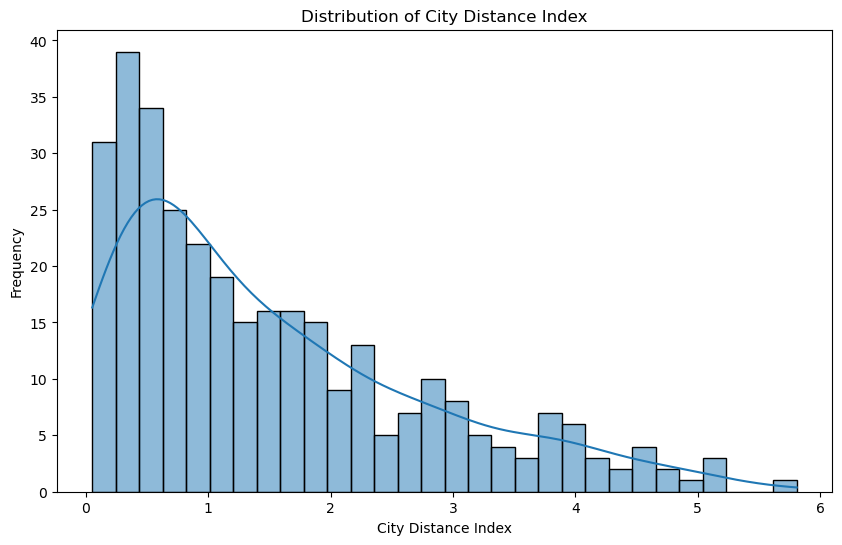

In [79]:
# plot the histogram of 'city_distance_index' column
plt.figure(figsize=(10, 6))
sns.histplot(city_pairs_all_df['city_distance_index_norm_e'], bins=30, kde=True)
plt.title('Distribution of City Distance Index')
plt.xlabel('City Distance Index')
plt.ylabel('Frequency')
plt.show()

In [81]:
# iterate over the city_pairs_df dataframe to add the edges to the network
# for each row's city1 and city2, add the edge between node city1 and node city2,
# the edge weight is the value of the 'city_distance_index' column
for idx, row in city_pairs_all_df.iterrows():
    city1 = row['city1']
    city2 = row['city2']
    distance = row['city_distance_index_norm_e']
    G_accessbility.add_edge(city1, city2, weight=distance)

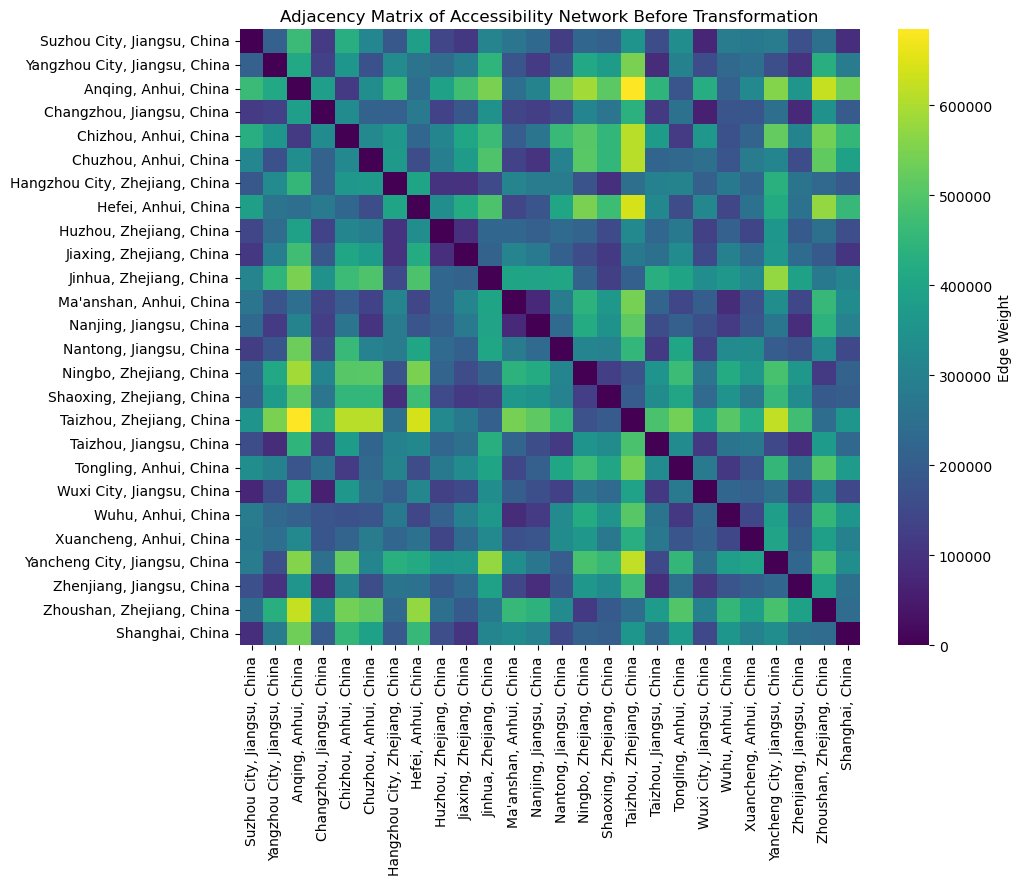

In [82]:
G_accessbility_2 = G_accessbility.copy()
for idx, row in city_pairs_all_df.iterrows():
    city1 = row['city1']
    city2 = row['city2']
    distance = row['city_distance_index']
    G_accessbility_2.add_edge(city1, city2, weight=distance)
adjacency_acc_2 = nx.to_numpy_array(G_accessbility_2)
#convert the adjacency_acc from a numpy array to a matrix as a dataframe
adjacency_acc_2df = pd.DataFrame(adjacency_acc_2, index=G_accessbility_2.nodes(), columns=G_accessbility_2.nodes())
# plot the heatmap of the adjacency matrix
plt.figure(figsize=(10, 8))
sns.heatmap(adjacency_acc_2df, cmap='viridis', cbar_kws={'label': 'Edge Weight'})
plt.title('Adjacency Matrix of Accessibility Network Before Transformation')
plt.show()

In [83]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis

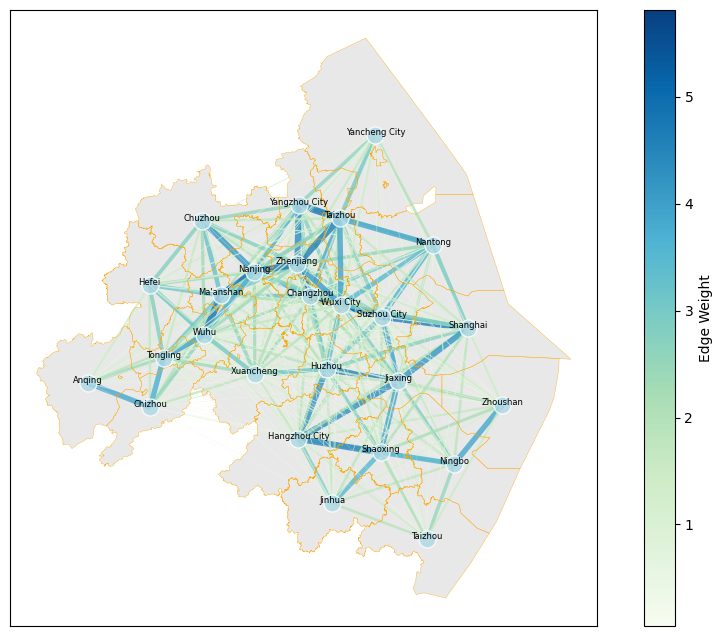

In [84]:
# get the node positions
pos = nx.get_node_attributes(G_accessbility, 'pos')

# Plot the nodes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the boundary of gdf
city_boundary.boundary.plot(ax=ax, edgecolor='orange', linewidth=0.25, alpha=1)

# Label the city name, set the font size to 5
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

# Fill the boundary with a color
city_boundary.plot(ax=ax, facecolor='lightgray', alpha=0.5)

# Normalize the weights for the colormap
weights = [data['weight'] for u, v, data in G_accessbility.edges(data=True)]
norm = Normalize(vmin=min(weights), vmax=max(weights))

# Create a ScalarMappable object with the colormap
sm = ScalarMappable(cmap='GnBu', norm=norm)

# Plot the edges with color mapping based on weights
edge_colors = [sm.to_rgba(data['weight']) for u, v, data in G_accessbility.edges(data=True)]
nx.draw_networkx_edges(G_accessbility, pos, ax=ax, edge_color=edge_colors, width=[data['weight'] for u, v, data in G_accessbility.edges(data=True)], arrows=False, alpha=0.8)

# Plot the nodes
nx.draw_networkx_nodes(G_accessbility, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

# Add a colorbar to the plot
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Edge Weight')

plt.show()

In [85]:
"""
# convert the G_accessbility graph to a dataframe matrix recording all weight between each pair of cities
city_distance_toy = nx.to_pandas_adjacency(G_accessbility, dtype=int)

# save it to csv and remain the index and columns names
city_distance_toy.to_csv('Data/python/city_distance_toy.csv', index=True, header=True)

"""

"\n# convert the G_accessbility graph to a dataframe matrix recording all weight between each pair of cities\ncity_distance_toy = nx.to_pandas_adjacency(G_accessbility, dtype=int)\n\n# save it to csv and remain the index and columns names\ncity_distance_toy.to_csv('Data/python/city_distance_toy.csv', index=True, header=True)\n\n"

### Community Detection

In [86]:
import numpy as np
import pandas as pd
import networkx as nx
import pygenstability as pgs
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.sparse import csr_array, csr_matrix
from scipy.sparse.csgraph import shortest_path
from pygenstability import plotting

In [87]:
# calculate the assortativity of the network G_accessbility, while it is a directed weighted network
# the assortativity is calculated based on the edge weight
assortativity = nx.degree_assortativity_coefficient(G_accessbility, weight='weight')
print(f'Degree assortativity coefficient: {assortativity}')

Degree assortativity coefficient: -0.03999999999999335


In [89]:
adjacency_acc = nx.to_numpy_array(G_accessbility)

In [90]:
#convert the adjacency_acc from a numpy array to a matrix as a dataframe
adjacency_acc_df = pd.DataFrame(adjacency_acc, index=G_accessbility.nodes(), columns=G_accessbility.nodes())

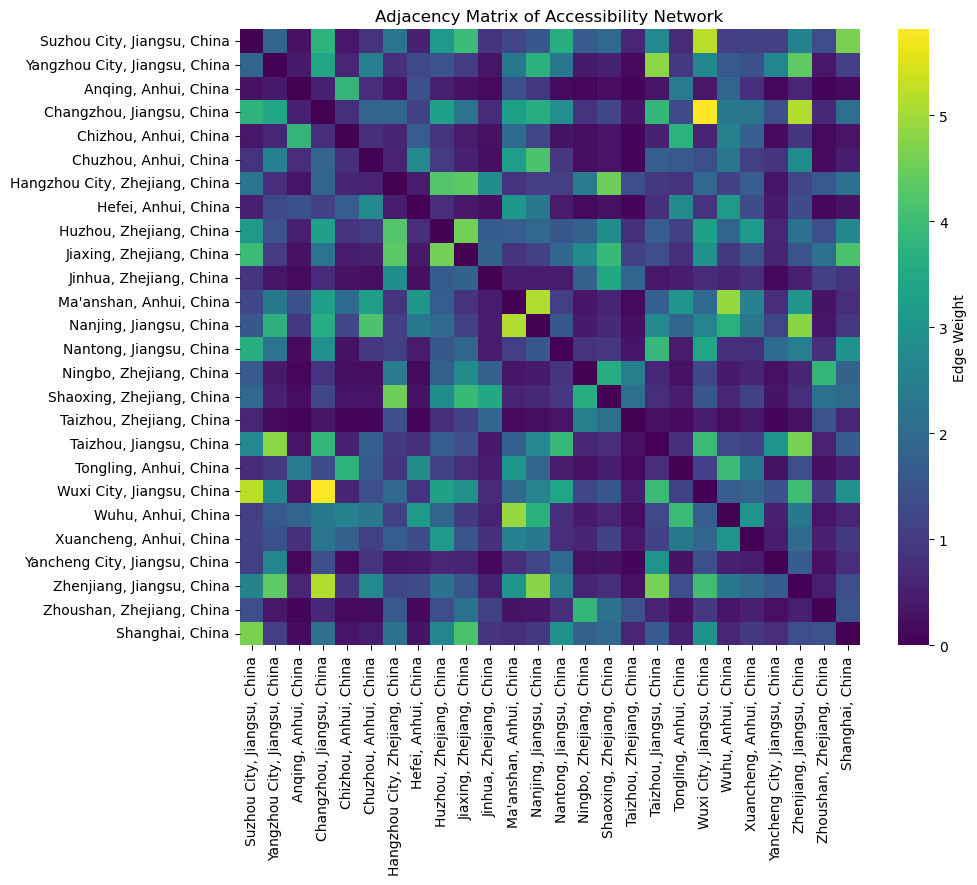

In [91]:
# plot the heatmap of the adjacency matrix
plt.figure(figsize=(10, 8))
sns.heatmap(adjacency_acc_df, cmap='viridis', cbar_kws={'label': 'Edge Weight'})
plt.title('Adjacency Matrix of Accessibility Network')
plt.show()


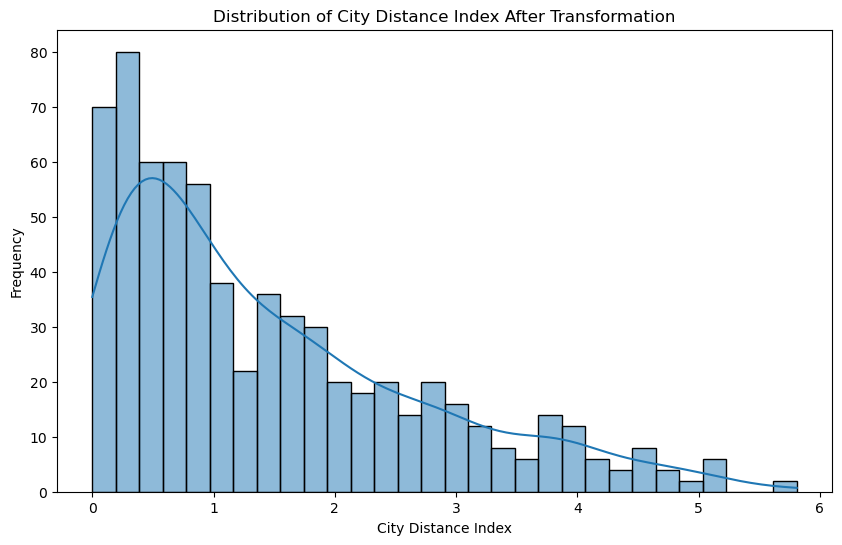

In [92]:
# plot the histogram of all the values in the adjacency_acc_df
plt.figure(figsize=(10, 6))
sns.histplot(adjacency_acc_df.values.flatten(), bins=30, kde=True)
plt.title('Distribution of City Distance Index After Transformation')
plt.xlabel('City Distance Index')
plt.ylabel('Frequency')
plt.show()

In [93]:
#normalize the adjacency_acc_2df by each row
adjacency_acc_2df= adjacency_acc_2df.div(adjacency_acc_2df.sum(axis=1), axis=0)


In [98]:
all_results = pgs.run(sp.sparse.csgraph.csgraph_from_dense(adjacency_acc_df), constructor='linearized', 
                    min_scale=-2, max_scale=2, n_scale=300, method='leiden', n_NVI=20,
                    log_scale=True, n_tries=400, with_spectral_gap=True)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:03<00:00, 93.89it/s] 


In [47]:
all_results.keys()

dict_keys(['run_params', 'scales', 'number_of_communities', 'stability', 'community_id', 'NVI', 'ttprime', 'block_detection_curve', 'selected_partitions'])

In [99]:
# check the number of each value in the number_of_communities
number_of_communities = all_results['number_of_communities']
number_of_communities = pd.Series(number_of_communities)
number_of_communities.value_counts()

26    236
1      33
3      31
Name: count, dtype: int64

In [100]:
all_results['scales'][198]

4.454812518844989

In [101]:
all_results['scales'][244]

18.374437246107266

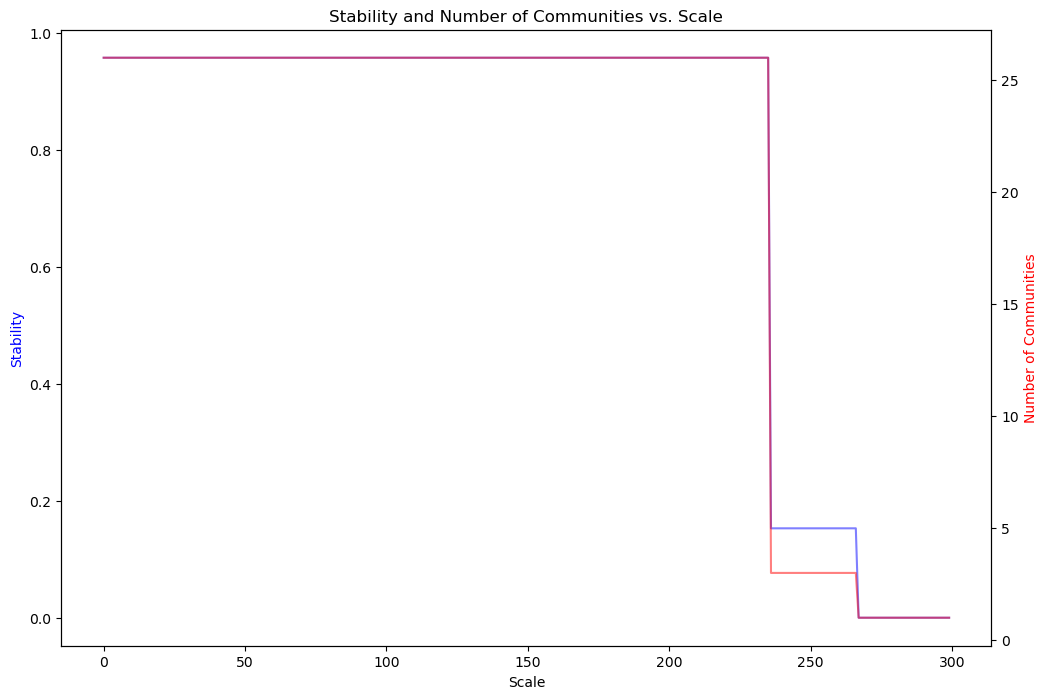

In [102]:
# plot all ['number of communities'] and ['stability'] in the all_results, and use left y-axis for stability and right y-axis for number of communities
plt.figure(figsize=(12, 8))
plt.plot(all_results['stability'], color='blue', alpha=0.5)
plt.ylabel('Stability', color='blue')
plt.xlabel('Scale')
plt.twinx()
plt.plot(all_results['number_of_communities'], color='red', alpha=0.5)
plt.ylabel('Number of Communities', color='red')
plt.title('Stability and Number of Communities vs. Scale')
plt.show()

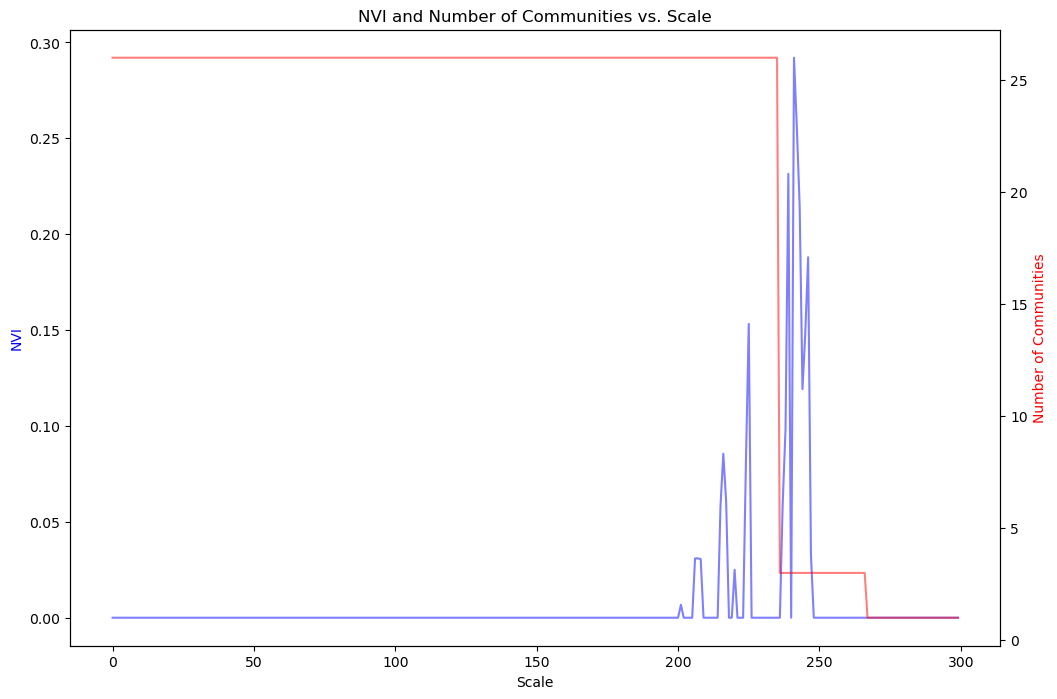

In [103]:
# plot all ['number of communities'] and ['stability'] in the all_results, and use left y-axis for stability and right y-axis for number of communities
plt.figure(figsize=(12, 8))
plt.plot(all_results['NVI'], color='blue', alpha=0.5)
plt.ylabel('NVI', color='blue')
plt.xlabel('Scale')
plt.twinx()
plt.plot(all_results['number_of_communities'], color='red', alpha=0.5)
plt.ylabel('Number of Communities', color='red')
plt.title('NVI and Number of Communities vs. Scale')
plt.show()

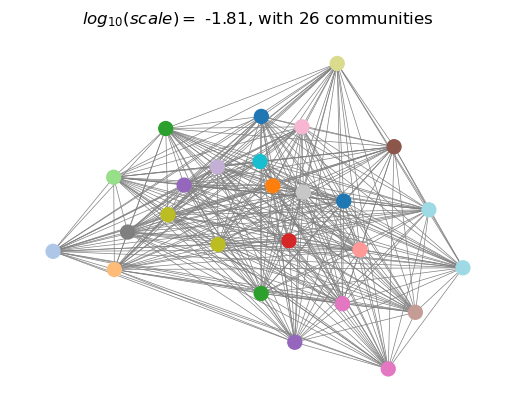

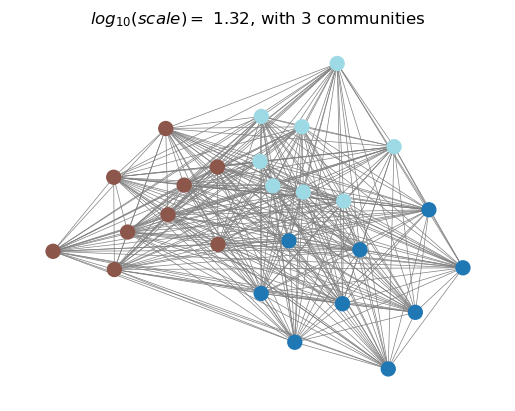

In [104]:
# plot optimal partitions
plotting.plot_optimal_partitions(G_accessbility, all_results, show=True)

In [41]:
pgs.plot_scan(all_results, scale_axis=True,
    figure_name="scan_results.pdf",
    use_plotly=False,
    live=False,
    plotly_filename="Results/scan_results.html")

[<Axes: xlabel='$log_{10}(t)$', ylabel='$log_{10}(t^\\prime)$'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='NVI'>,
 <Axes: ylabel='Stability'>,
 <Axes: ylabel='# clusters'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='Block NVI'>]

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 640x480 with 6 Axes>

In [105]:
community_3 = all_results['community_id'][250]
for idx, node in enumerate(G_accessbility.nodes()):
    G_accessbility.nodes[node]['community_id3'] = community_3[idx]

In [106]:
G_accessbility.nodes(data=True)

NodeDataView({'Suzhou City, Jiangsu, China': {'pos': (120.653679024957, 31.38078072150929), 'community_id3': 2}, 'Yangzhou City, Jiangsu, China': {'pos': (119.47278615885945, 32.73807751484801), 'community_id3': 2}, 'Anqing, Anhui, China': {'pos': (116.48716384016682, 30.575870185123257), 'community_id3': 1}, 'Changzhou, Jiangsu, China': {'pos': (119.63652452918636, 31.625699787531467), 'community_id3': 2}, 'Chizhou, Anhui, China': {'pos': (117.36605652914939, 30.283782530856126), 'community_id3': 1}, 'Chuzhou, Anhui, China': {'pos': (118.10239695333057, 32.54418944808414), 'community_id3': 1}, 'Hangzhou City, Zhejiang, China': {'pos': (119.47041554104271, 29.90033741984645), 'community_id3': 0}, 'Hefei, Anhui, China': {'pos': (117.35654447030245, 31.763366059762376), 'community_id3': 1}, 'Huzhou, Zhejiang, China': {'pos': (119.8689629869284, 30.744517137471792), 'community_id3': 0}, 'Jiaxing, Zhejiang, China': {'pos': (120.88624669601344, 30.601748621552154), 'community_id3': 0}, 'Jin

In [107]:
# substract each nodes' name, community_id6, and community_id2 to a pandas dataframe
node_df = pd.DataFrame(G_accessbility.nodes(data=True))
node_df['city_name'] = node_df[0].apply(lambda x: x)
node_df['community_id3'] = node_df[1].apply(lambda x: x['community_id3'])
node_df = node_df.drop([0, 1], axis=1)
# set the city_name as the index
node_df = node_df.set_index('city_name')
node_df.sample(3)

,community_id3
city_name,
"Yancheng City, Jiangsu, China",2
"Chizhou, Anhui, China",1
"Ma'anshan, Anhui, China",1


In [113]:
node_df['Province'] = ""

In [123]:
# substract the province name from the city name, the province name is the string between the first ',' and the end
node_df['Province'] = node_df.index.str.split(',').str[1]
# convert the province name to the number as the type of category, same province has the same number, from 0 to n
node_df['Province'] = node_df['Province'].astype('category').cat.codes

node_df.sample(3)

,community_id3,Province
city_name,,
"Changzhou, Jiangsu, China",2,2
"Taizhou, Zhejiang, China",0,3
"Tongling, Anhui, China",1,0


In [124]:
city_boundary = city_boundary.merge(node_df[['Province']], left_on='display_na', right_index=True, how='left')

C:\Users\SBH\AppData\Local\Temp\ipykernel_26760\1426640082.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



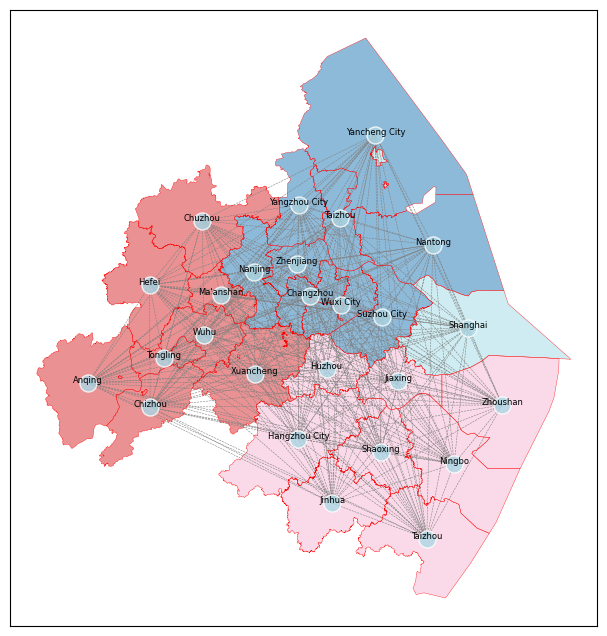

In [125]:
# 生成颜色映射
unique_communities = node_df['Province'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_communities))
community_color_map = {community: colors(i) for i, community in enumerate(unique_communities)}

# 创建图形
fig, ax = plt.subplots(figsize=(12, 8))

# 填充边界颜色
for community in unique_communities:
    boundary_community = city_boundary[city_boundary['Province'] == community]
    boundary_community.plot(ax=ax, facecolor=community_color_map[community], alpha=0.5, edgecolor='none')

# Plot the boundary outline
city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)

# Label the city name, set the font size to 6
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

# 获取节点位置
pos = nx.get_node_attributes(G_accessbility, 'pos')

# 绘制节点
nx.draw_networkx_nodes(G_accessbility, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

# 绘制边，使用宽度来显示边的权重
nx.draw_networkx_edges(G_accessbility, pos, edge_color='gray', width=0.4, style='dashed')
plt.show()

In [119]:
city_boundary = city_boundary.merge(node_df[['community_id3']], left_on='display_na', right_index=True, how='left')

C:\Users\SBH\AppData\Local\Temp\ipykernel_26760\3406023109.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



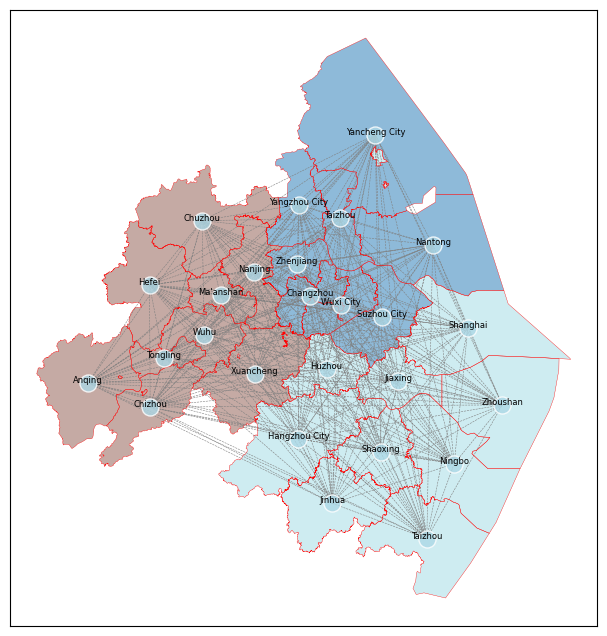

In [120]:
# 生成颜色映射
unique_communities = node_df['community_id3'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_communities))
community_color_map = {community: colors(i) for i, community in enumerate(unique_communities)}

# 创建图形
fig, ax = plt.subplots(figsize=(12, 8))

# 填充边界颜色
for community in unique_communities:
    boundary_community = city_boundary[city_boundary['community_id3'] == community]
    boundary_community.plot(ax=ax, facecolor=community_color_map[community], alpha=0.5, edgecolor='none')

# Plot the boundary outline
city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)

# Label the city name, set the font size to 6
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

# 获取节点位置
pos = nx.get_node_attributes(G_accessbility, 'pos')

# 绘制节点
nx.draw_networkx_nodes(G_accessbility, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

# 绘制边，使用宽度来显示边的权重
nx.draw_networkx_edges(G_accessbility, pos, edge_color='gray', width=0.4, style='dashed')
plt.show()

### Derdrogram

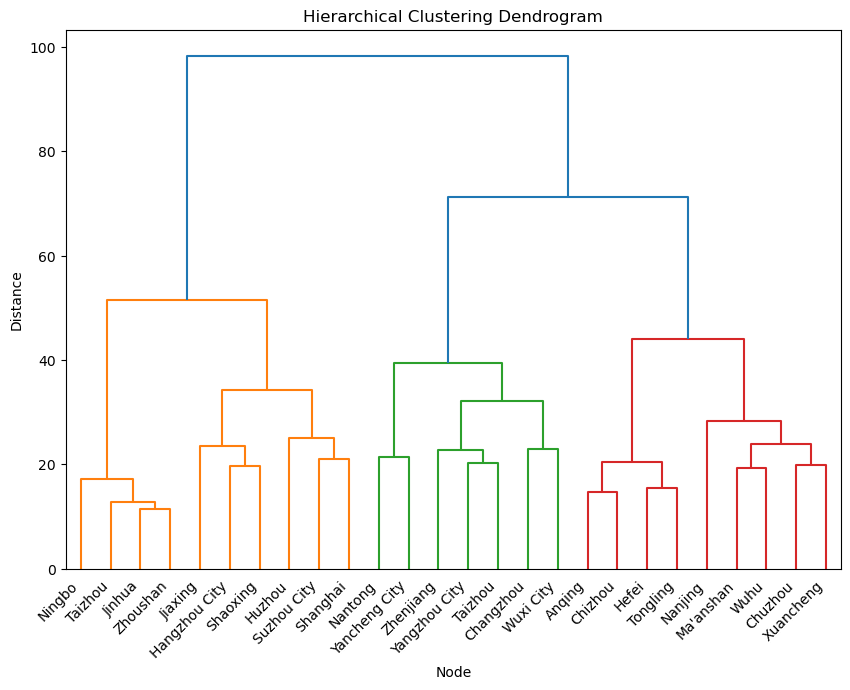

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform


# 计算邻接矩阵
adj_matrix = nx.to_numpy_array(G_accessbility)

# 计算距离矩阵（这里使用自定义的距离计算方法）
def custom_distance(u, v):
    return np.sum(np.abs(u - v))

# 计算距离矩阵
n = len(G_accessbility)
distance_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        distance_matrix[i, j] = custom_distance(adj_matrix[i], adj_matrix[j])
        distance_matrix[j, i] = distance_matrix[i, j]

# 将距离矩阵转化为上三角形式
condensed_distance_matrix = squareform(distance_matrix)

# 进行层次聚类
Z = linkage(condensed_distance_matrix, method='ward')

# 绘制dendrogram, label的对齐方式是居中，旋转角度为45度

plt.figure(figsize=(10, 7))
dendrogram(Z, labels=list(city_boundary['name']), leaf_rotation=45)
plt.title('Hierarchical Clustering Dendrogram')
# 获取所有标签并设置对齐方式为居中
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_ha('right')  # 水平居中对齐
plt.xlabel('Node')
plt.ylabel('Distance')
plt.show()



In [ ]:
node_df.sample(5)

,community_id3
city_name,
"Nanjing, Jiangsu, China",0
"Changzhou, Jiangsu, China",2
"Chuzhou, Anhui, China",0
"Suzhou City, Jiangsu, China",2
"Taizhou, Zhejiang, China",1


In [ ]:
# save the node_df to a csv file
#node_df.to_csv('Data/python/Partition_road.csv')

In [ ]:
list(G_accessbility.nodes(data=True))[0:2]

[('Suzhou City, Jiangsu, China',
  {'pos': (120.653679024957, 31.38078072150929), 'community_id3': 2}),
 ('Yangzhou City, Jiangsu, China',
  {'pos': (119.47278615885945, 32.73807751484801), 'community_id3': 2})]

In [ ]:
G_accessbility_save = G_accessbility.copy()

In [ ]:
"""
# 遍历节点，清理属性
for node, data in G_accessbility_save.nodes(data=True):
    for key, value in data.items():
        if isinstance(value, tuple):
            data[key] = str(value)  # 将 tuple 转换为字符串

# 遍历边，清理属性
for u, v, data in G_accessbility_save.edges(data=True):
    for key, value in data.items():
        if isinstance(value, tuple):
            data[key] = str(value)  # 将 tuple 转换为字符串

# 保存图为 GraphML 文件
nx.write_graphml(G_accessbility_save, 'Data/python/Spatial_network.graphml')
"""

"\n# 遍历节点，清理属性\nfor node, data in G_accessbility_save.nodes(data=True):\n    for key, value in data.items():\n        if isinstance(value, tuple):\n            data[key] = str(value)  # 将 tuple 转换为字符串\n\n# 遍历边，清理属性\nfor u, v, data in G_accessbility_save.edges(data=True):\n    for key, value in data.items():\n        if isinstance(value, tuple):\n            data[key] = str(value)  # 将 tuple 转换为字符串\n\n# 保存图为 GraphML 文件\nnx.write_graphml(G_accessbility_save, 'Data/python/Spatial_network.graphml')\n"